In [8]:
from flyingpigeon import weatherregimes as wr
from flyingpigeon import utils
from os import listdir, path ,getenv

HOME = getenv('HOME')

In [9]:
from flyingpigeon.visualisation import plot_kMEAN, plot_pressuremap, concat_images
from IPython.display import Image
from numpy import ma, mean

In [10]:
#p = HOME + '/.conda/envs/birdhouse/var/lib/cache/pywps/www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep.reanalysis.dailyavgs/surface'
#observation = [path.join(p,f) for f in listdir(p)]

observation = wr.get_NCEP()

p = HOME+'/.conda/envs/birdhouse/var/lib/cache/pywps/esgf1.dkrz.de/thredds/fileServer/cmip5/cmip5/output1/MPI-M/MPI-ESM-LR/historical/day/atmos/day/r1i1p1/v20111006/psl'
model = [path.join(p,f) for f in listdir(p)]

In [11]:
reload(wr)
nc_obs = wr.subset(observation, bbox="-80,50,22.5,70", time_region='12,1,2')
nc_model = wr.subset(model, bbox="-80,50,22.5,70", time_region='12,1,2', regrid_destination=nc_obs)

/home/nils/birdhouse/flyingpigeon/notebooks/6714021e-021b-11e6-b233-9d323db51d97.nc
performing remaping
output = cdo.remapbil('/home/nils/birdhouse/flyingpigeon/notebooks/tmpakL7X6.nc',input='/home/nils/birdhouse/flyingpigeon/notebooks/912f2f2e-021b-11e6-b233-9d323db51d97.nc', output='e47f154a-021b-11e6-b233-9d323db51d97.nc')
e47f154a-021b-11e6-b233-9d323db51d97.nc


variable name: slp


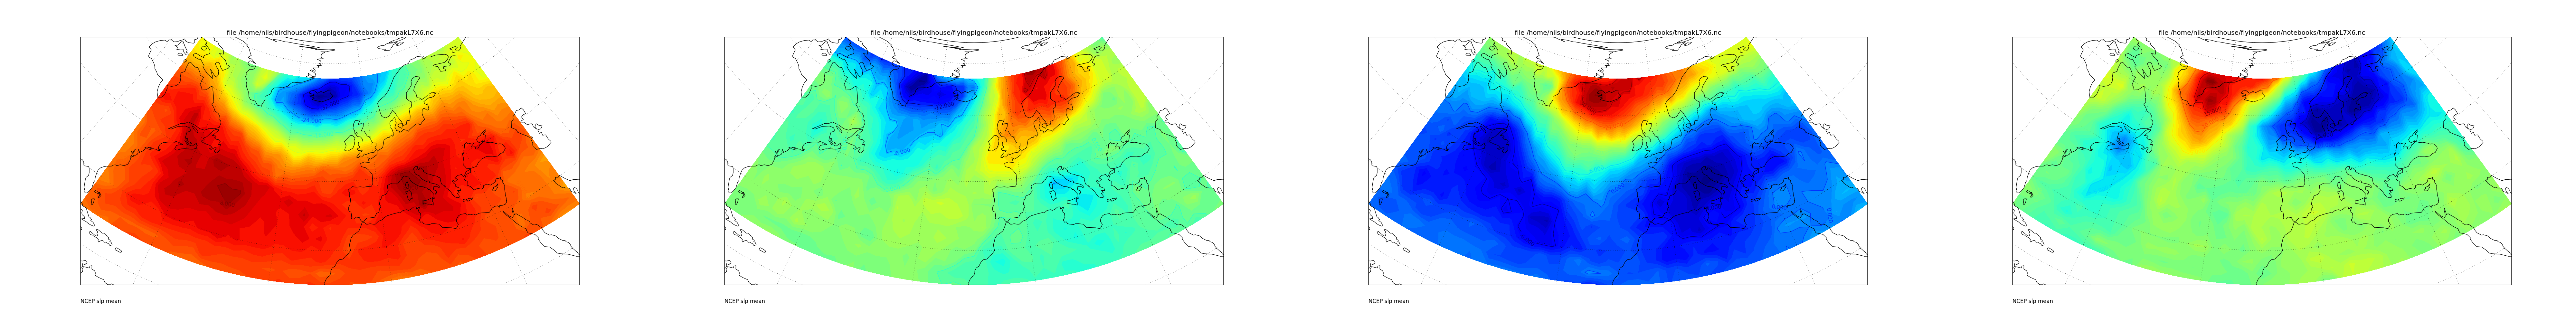

In [12]:
file = nc_obs
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)

subplots = []
obs_pattern = []
for i in range(4):
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    pattern = mean(data[best_pattern], axis = 0)
    obs_pattern.append(pattern)
    subplots.append(plot_pressuremap(pattern, 
    lats=lats, 
    lons=lons, 
    title='file %s' % file , 
    sub_title='NCEP slp mean'))
#    regime_dic['NCEP']['weather regime %s' % i] = mean(data_ncep[best_pattern], axis = 0)

con = concat_images(subplots, orientation='h')
Image(filename=con)

variable name: psl


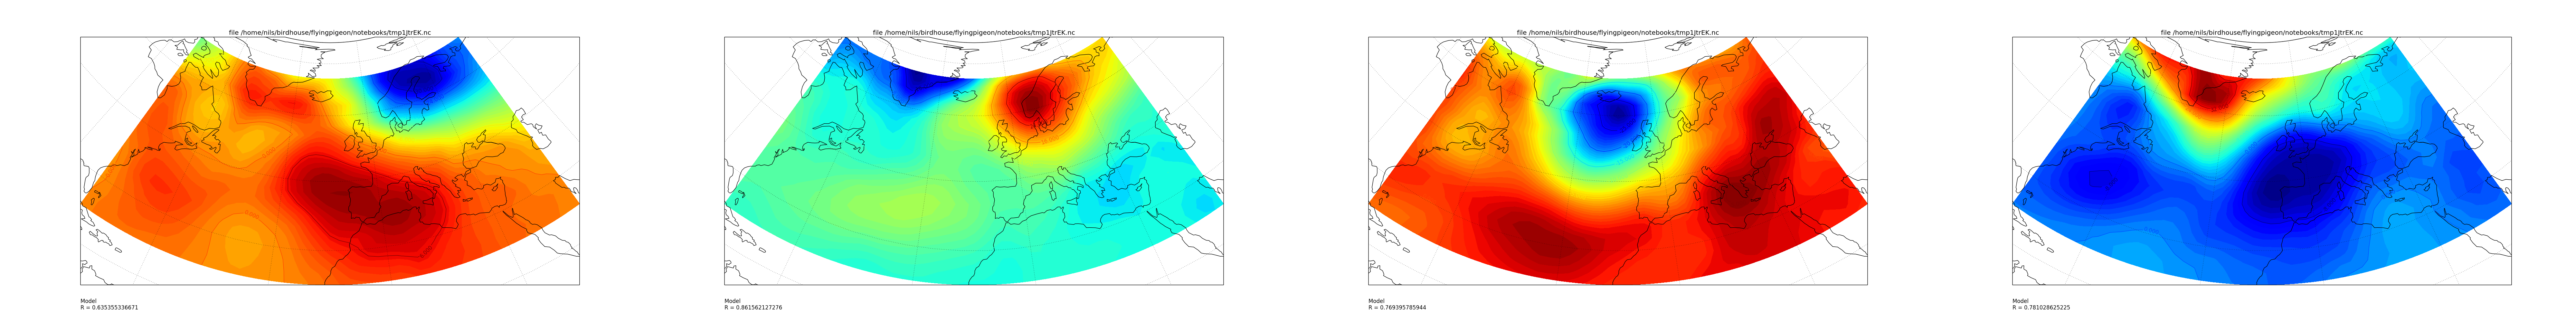

In [33]:
file = nc_model
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)

import numpy as np 
from scipy import stats

subplots = []
model_pattern = []
stat_vals = np.empty([4, 5])
order = np.empty([4])
m, n  = obs_pattern[0].shape

for i in range(4):
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    pattern = mean(data[best_pattern], axis = 0)
    model_pattern.append(pattern)
    
        #### compare with observation    
    for j in [0,1,2,3]: 
        x = np.reshape(obs_pattern[j], (n*m))
        y = np.reshape(model_pattern[i], (n*m))
        if j == 0:
            alpha, beta, r_value, p_value, std_err = stats.linregress(x, y)
            stat_vals[i] = [alpha, beta, r_value, p_value, std_err]
            order[i] = j 
        else:
            alpha, beta, r_value, p_value, std_err = stats.linregress(x, y)
            if r_value > stat_vals[i][2]:
                stat_vals[i] = [alpha, beta, r_value, p_value, std_err]
                order[i] = j
    
    subplots.append(plot_pressuremap(pattern,
    lats=lats, 
    lons=lons, 
    title='file %s' % file , 
    sub_title='Model \nR = %s \n' % stat_vals[i][2] ))

subplots_ordered = [subplots[int(i)] for i in order]
con = concat_images(subplots_ordered, orientation='h')
Image(filename=con)